Simulation progress: 0.00% complete (Step 0 of 2880)
Simulation progress: 34.72% complete (Step 1000 of 2880)
Simulation progress: 69.44% complete (Step 2000 of 2880)


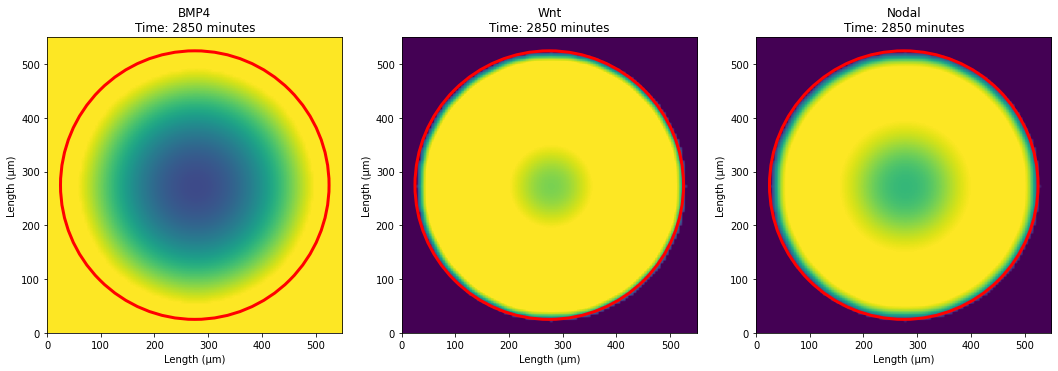

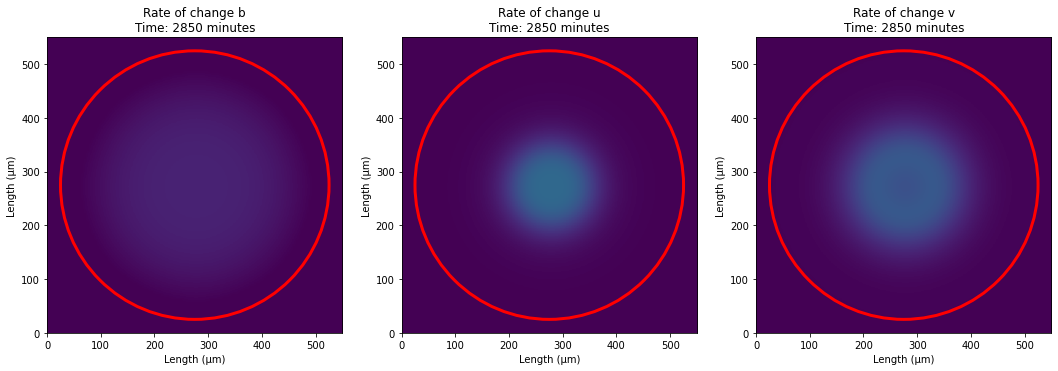

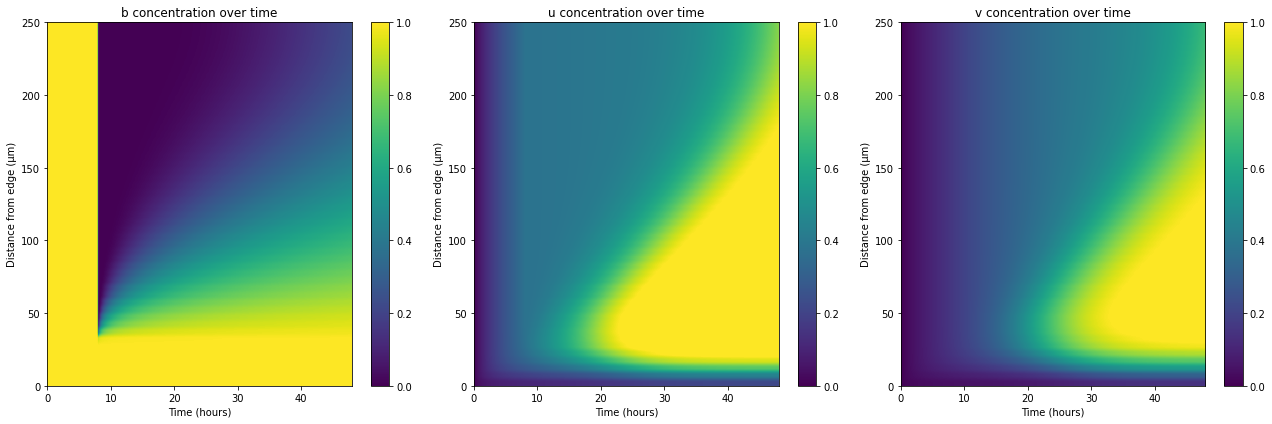

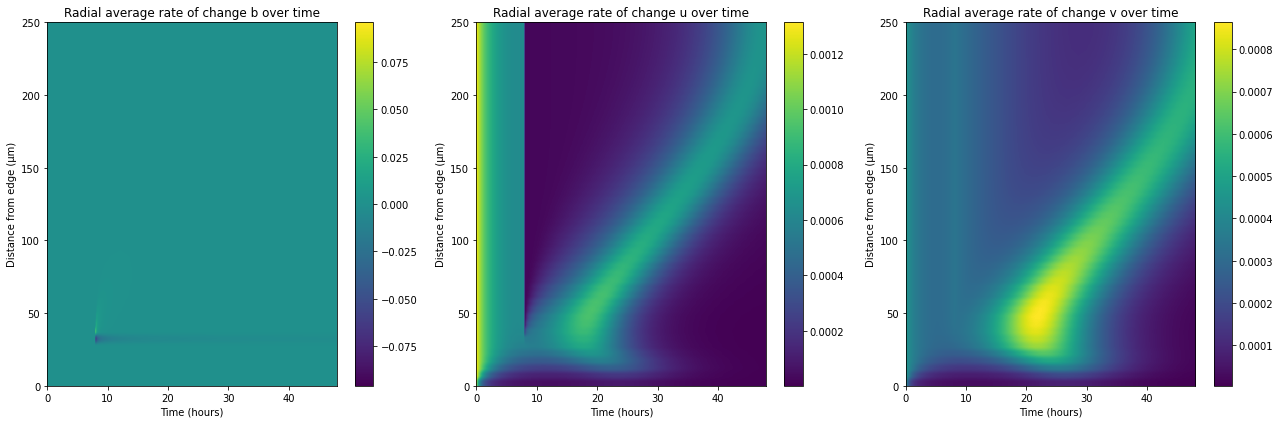

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.cm import viridis
import math 


cell_count = 750  # This can be any cell count value

r_loc_mult = 1-np.exp(-.00268*cell_count)


# Real-world diffusion coefficients in microns^2/s
D_u_real = 0.1
D_v_real = 0.1
D_b_real = 1

# Additional parameters
su = 0.05 * 2.1e-3 * 60
sv = 0.05 * 2.1e-3 * 60
ku = 0.05 * 1.4e-3 * 60
kv = 0.05 * 1.0e-3 * 60
kb = 0.05 * 2.0e-4 * 60 
cu = 0.05 * 2.2e-4 * 60 
cv = 0.05 * 1.5e-4 * 60

Ku = 0.8
Kv = 1.5

#density dependent variable
scaling_factor = 0.20
Kd = (1 - scaling_factor * (cell_count / 950 - 1))


# Simulation settings
dx = 5  # micrometers
grid_size = 110
D_u_per_minute = D_u_real * 60 / (dx**2)
D_v_per_minute = D_v_real * 60 / (dx**2)
D_b_per_minute = D_b_real * 60 / (dx**2)
physical_r_rad = 250  # Radius in micrometers
r_rad = physical_r_rad / dx
#r_loc = ((15*r_rad)/16)
r_loc = r_rad*r_loc_mult
t_loc = 480  # minutes
dt = 1#0.1 * dx**2 / (2 * max(D_u_per_minute, D_v_per_minute, D_b_per_minute))
total_time = 48 * 60  # minutes
frame_interval = 30  # minutes

# Initialize grids
u = np.zeros((grid_size, grid_size))
v = np.zeros((grid_size, grid_size))
b = np.ones((grid_size, grid_size))

# Center and boundary masks
center = np.array([grid_size // 2, grid_size // 2])
X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
boundary_mask_u_v = dist_from_center > r_rad
boundary_mask_b = dist_from_center > r_loc

# Reaction functions
def f(u): return (su * u**2) / (1 + Ku * u**4)
def g(u, v): return ((sv * v) / ((1 + Kv * v**2)) * u) 

# General Laplacian function
def laplacian(grid):
    lap = np.zeros_like(grid)
    lap[1:-1, 1:-1] = (
        grid[2:, 1:-1] + grid[:-2, 1:-1] +
        grid[1:-1, 2:] + grid[1:-1, :-2] -
        4 * grid[1:-1, 1:-1]) / dx**2
    return lap

def update_uv(u, v, b, dt):
    
    u[boundary_mask_u_v] = 0  # Ensure u is 0 outside r_rad
    v[boundary_mask_u_v] = 0  # Ensure v is 0 outside r_rad
    
    laplacian_u = laplacian(u)
    laplacian_v = laplacian(v)
    du_dt = (D_u_per_minute * laplacian_u) + (Kd * (f(u)  + (kb * b) + cu)) - (ku * u)
    dv_dt = (D_v_per_minute * laplacian_v) + (g(u, v) - kv * v) + cv
    
    # Apply boundary conditions to rates
    du_dt[boundary_mask_u_v] = 0
    dv_dt[boundary_mask_u_v] = 0
    
    u_next = u + dt * du_dt
    v_next = v + dt * dv_dt
    
    return u_next, v_next, du_dt, dv_dt

def update_b(b, dt, current_time, b_updated):
    
    b[boundary_mask_b] = 1  # Ensure b is 1 outside r_loc
    #b[boundary_mask_u_v] = 0  # Ensure b is 0 outside r_rad
    
    if current_time > t_loc and not b_updated:
        b[dist_from_center <= r_loc] = 0  # Change b inside r_loc
        b_updated = True
        
    laplacian_b = laplacian(b)
    db_dt = D_b_per_minute * laplacian_b
    
    # Apply boundary conditions to rates
    #db_dt[boundary_mask_b] = 0
    
    b_next = b + dt * db_dt
    
    return b_next, b_updated, db_dt

# Simulation loop
num_steps = int(total_time / dt)
current_time = 0

# Initialize data storage
animation_data = []
animation_data_rate = []
radial_concentration = []
radial_concentration_rates = []

b_updated = False  # Initialize b_updated flag

for step in range(num_steps):
    if step % 1000 == 0:
        print(f"Simulation progress: {(step / num_steps) * 100:.2f}% complete (Step {step} of {num_steps})")
    
    # Perform updates
    b, b_updated, db_dt = update_b(b, dt, current_time, b_updated)
    u, v, du_dt, dv_dt = update_uv(u, v, b, dt)

    # Store data for animations at specified intervals
    if current_time % frame_interval < dt:
        animation_data.append((u.copy(), v.copy(), b.copy(), current_time))
        animation_data_rate.append((du_dt, dv_dt, db_dt, current_time))

    # Calculate radial averages for concentrations and store them
    dist_from_edge = r_rad - dist_from_center
    radial_conc_u = np.array([np.mean(u[dist_from_edge == r]) for r in range(int(r_rad))])
    radial_conc_v = np.array([np.mean(v[dist_from_edge == r]) for r in range(int(r_rad))])
    radial_conc_b = np.array([np.mean(b[dist_from_edge == r]) for r in range(int(r_rad))])
    radial_concentration.append((radial_conc_u, radial_conc_v, radial_conc_b, current_time))

    # Calculate radial averages for rates of change and store them
    radial_change_u = np.array([np.mean(du_dt[dist_from_edge == r]) for r in range(int(r_rad))])
    radial_change_v = np.array([np.mean(dv_dt[dist_from_edge == r]) for r in range(int(r_rad))])
    radial_change_b = np.array([np.mean(db_dt[dist_from_edge == r]) for r in range(int(r_rad))])
    radial_concentration_rates.append((radial_change_u, radial_change_v, radial_change_b, current_time))

    current_time += dt

# Function to update animation
def update_animation(num, data, axes):
    u, v, b, t = data[num]
    titles = ['BMP4', 'Wnt', 'Nodal']
    for ax, d, title in zip(axes, [b, u, v], titles):
        ax.clear()
        ax.imshow(d, cmap=viridis, extent=[0, grid_size*dx, 0, grid_size*dx], vmin=0, vmax=1)
        ax.set_title(f'{title}\nTime: {t:.0f} minutes')
        ax.set_xlabel('Length (μm)')
        ax.set_ylabel('Length (μm)')
        colony_circle = plt.Circle((center[0]*dx, center[1]*dx), r_rad*dx, color='red', fill=False, linewidth=3)
        ax.add_patch(colony_circle)
        
def update_animation_rate(num, data, axes):
    du_dt, dv_dt, db_dt, t = data[num]
    titles = ['Rate of change b', 'Rate of change u', 'Rate of change v']
    
    for ax, d, title in zip(axes, [db_dt, du_dt, dv_dt], titles):
        ax.clear()
        ax.imshow(d, cmap=viridis, extent=[0, grid_size * dx, 0, grid_size * dx], vmin=0, vmax=.002)
        ax.set_title(f'{title}\nTime: {t:.0f} minutes')
        ax.set_xlabel('Length (μm)')
        ax.set_ylabel('Length (μm)')
        colony_circle = plt.Circle((center[0] * dx, center[1] * dx), r_rad * dx, color='red', fill=False, linewidth=3)
        ax.add_patch(colony_circle)

# Create animations
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
conc_ani = FuncAnimation(fig, update_animation, frames=len(animation_data),
                         fargs=(animation_data, axes), interval=200, blit=False)
conc_ani.save('concentration_simulation.mp4', fps=12, extra_args=['-vcodec', 'libx264'])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
rate_ani = FuncAnimation(fig, update_animation_rate, frames=len(animation_data_rate),
                         fargs=(animation_data_rate, axes), interval=200, blit=False)
rate_ani.save('rate_of_change_animation.mp4', fps=12, extra_args=['-vcodec', 'libx264'])

plt.show()

# Extract data for radial concentration heatmaps
radial_conc_data_u = np.array([data[0] for data in radial_concentration])
radial_conc_data_v = np.array([data[1] for data in radial_concentration])
radial_conc_data_b = np.array([data[2] for data in radial_concentration])

# Create heatmaps for radial concentration
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['b', 'u', 'v']
for i, data in enumerate([radial_conc_data_b, radial_conc_data_u, radial_conc_data_v]):
    heatmap_data = data.T
    im = axes[i].imshow(heatmap_data, cmap=viridis, aspect='auto', extent=[0, total_time / 60, 0, physical_r_rad], origin='lower', vmin=0, vmax=1)
    axes[i].set_title(f'{titles[i]} concentration over time')
    axes[i].set_xlabel('Time (hours)')
    axes[i].set_ylabel('Distance from edge (μm)')
    plt.colorbar(im, ax=axes[i])
plt.tight_layout()
plt.savefig('morphogen_over_time.png')
plt.show()


# Extract data for radial concentration rate heatmaps
radial_rate_data_u = np.array([data[0] for data in radial_concentration_rates])
radial_rate_data_v = np.array([data[1] for data in radial_concentration_rates])
radial_rate_data_b = np.array([data[2] for data in radial_concentration_rates])

# Create heatmaps for radial concentration rates
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
radial_rate_titles = ['Radial average rate of change b', 'Radial average rate of change u', 'Radial average rate of change v']
for i, data in enumerate([radial_rate_data_b, radial_rate_data_u, radial_rate_data_v]):
    heatmap_data = data.T
    im = axes[i].imshow(heatmap_data, cmap=viridis, aspect='auto', extent=[0, total_time / 60, 0, physical_r_rad], origin='lower')
    axes[i].set_title(f'{radial_rate_titles[i]} over time')
    axes[i].set_xlabel('Time (hours)')
    axes[i].set_ylabel('Distance from edge (μm)')
    plt.colorbar(im, ax=axes[i])
plt.tight_layout()
plt.savefig('radial_rate_of_change_over_time.png')
plt.show()

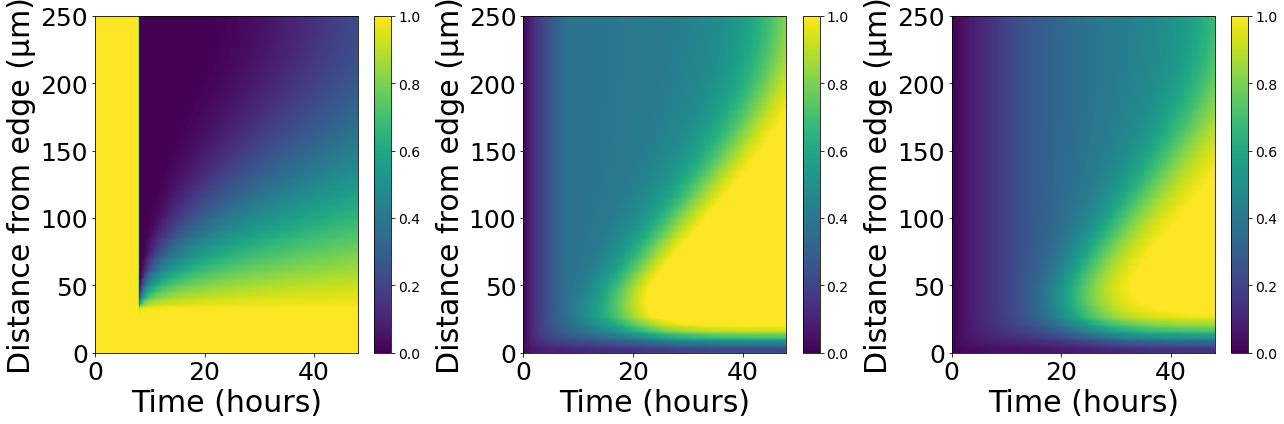

In [3]:
# Create heatmaps for radial concentration
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
titles = ['b', 'u', 'v']
for i, data in enumerate([radial_conc_data_b, radial_conc_data_u, radial_conc_data_v]):
    heatmap_data = data.T
    im = axes[i].imshow(heatmap_data, cmap=viridis, aspect='auto', extent=[0, total_time / 60, 0, physical_r_rad], origin='lower', vmin=0, vmax=1)
    #axes[i].set_title(f'{titles[i]} concentration over time', fontsize=16)
    axes[i].set_xlabel('Time (hours)', fontsize=30)
    axes[i].set_ylabel('Distance from edge (μm)', fontsize=30)
    axes[i].tick_params(axis='both', which='major', labelsize=25) 
    plt.colorbar(im, ax=axes[i]).ax.tick_params(labelsize=14)

# Adjust the overall layout and save/show the figure
plt.tight_layout()
plt.savefig('morphogen_over_time.png')
plt.show()

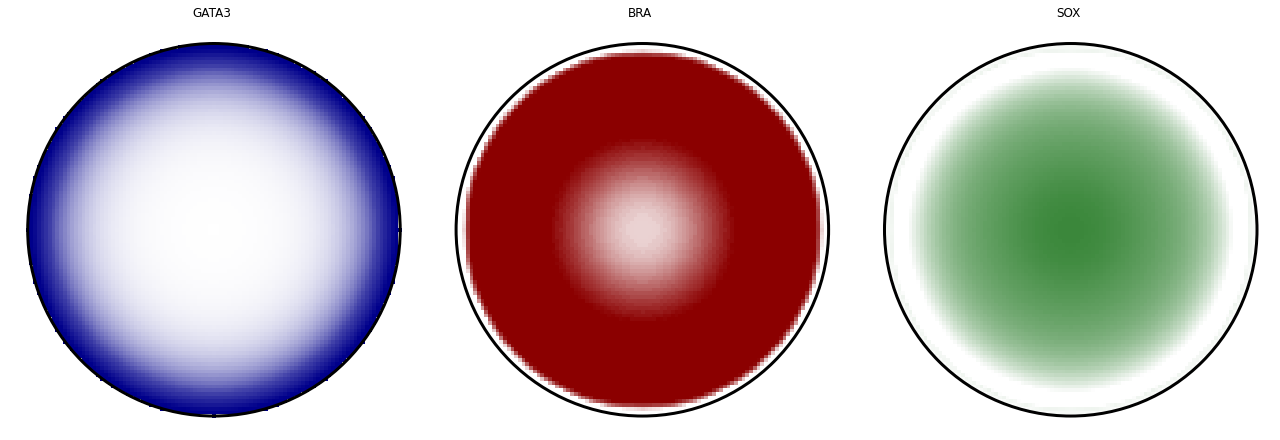

In [4]:
#CELL DATE RULES

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image, ImageChops

#GATA CALCULATION
# Integrate the morphogen concentrations over time using animation_data
integral_b = np.sum([frame[2] for frame in animation_data], axis=0) * dt # frame[2] is the b concentration

Cg = 0.1 #steepness of GATA dropoff

# Calculate the GATA expression 
GATA_expression = integral_b / (1 + np.exp(-Cg*(dist_from_center-r_rad)))


# Apply the boundary mask
GATA_expression[boundary_mask_u_v] = 0


# BRA CALCULATION
cumulative_change_v = np.zeros_like(animation_data[0][0])

# Loop over each frame (the first element of each rate_frame tuple is the rate of change of v)
for frame, rate_frame in zip(animation_data, animation_data_rate):
    u = frame[0]  # Concentration of u
    rate_change_v = rate_frame[1]  # Rate of change of v
    
    # Check the conditions
    condition_met = (u > 0.7)
    
    # Calculate the cumulative change where conditions are met
    cumulative_change_v += condition_met * rate_change_v * dt

# Assuming the BRA expression is proportional to the cumulative change in v
BRA_expression = cumulative_change_v*3300

# Apply the boundary mask
BRA_expression[boundary_mask_u_v] = 0

integral_u = np.sum([frame[0] for frame in animation_data], axis=0) * dt


#SOX CALCULATION
SOX_expression = np.maximum(0, 1*(48-GATA_expression-0.20*BRA_expression))


# Apply the boundary mask
SOX_expression[boundary_mask_u_v] = 0


# Normalize G, B, and S to their approximate 25th and 75th percentile values
G_normalized = (GATA_expression / 45)
B_normalized = (BRA_expression/ 50)
S_normalized = (SOX_expression / 60)


# Define custom colormaps for GATA3, BRA, and SOX
gata3_cmap = LinearSegmentedColormap.from_list('gata3_cmap', ['white', 'darkblue'], N=256)
bra_cmap = LinearSegmentedColormap.from_list('bra_cmap', ['white', 'darkred'], N=256)
sox_cmap = LinearSegmentedColormap.from_list('sox_cmap', ['white', 'darkgreen'], N=256)

# Plot each channel independently and then save each plot as its own .png file
for i, (data, cmap, title) in enumerate(zip([G_normalized, B_normalized, S_normalized],
                                            [gata3_cmap, bra_cmap, sox_cmap],
                                            ['GATA3', 'BRA', 'SOX'])):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(data, cmap=cmap, vmin=0, vmax=1)
    ax.axis('off')  # Turn off the axis
    colony_circle = plt.Circle(center, r_rad, color='black', fill=False, linewidth=3)
    ax.add_patch(colony_circle)
    plt.savefig(f'{title}.png')  # Save the plot
    plt.close(fig)

# Plotting the figure that shows all 3 channels
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, (data, cmap, title) in enumerate(zip([G_normalized, B_normalized, S_normalized],
                                            [gata3_cmap, bra_cmap, sox_cmap],
                                            ['GATA3', 'BRA', 'SOX'])):
    axs[i].imshow(data, cmap=cmap, vmin=0, vmax=1)
    axs[i].set_title(title)
    axs[i].axis('off')  # Turn off the axis
    colony_circle = plt.Circle(center, r_rad, color='black', fill=False, linewidth=3)
    axs[i].add_patch(colony_circle)

plt.tight_layout()
plt.savefig('All_Channels.png')  # Save the plot
plt.show()

# Load the images
gata3_img = Image.open('GATA3.png').convert('RGBA')
bra_img = Image.open('BRA.png').convert('RGBA')
sox_img = Image.open('SOX.png').convert('RGBA')

# Composite the images
composite = ImageChops.multiply(gata3_img, bra_img)
composite = ImageChops.multiply(composite, sox_img)

# Save the composite image
composite_path = 'Composite_Fate_Map.png'
composite.save(composite_path)

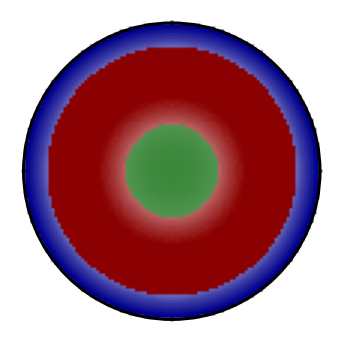

In [5]:
#COMPOSITE IMAGE

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormaps for GATA3, BRA, and SOX
gata3_cmap = LinearSegmentedColormap.from_list('gata3_cmap', ['white', 'darkblue'], N=256)
bra_cmap = LinearSegmentedColormap.from_list('bra_cmap', ['white', 'darkred'], N=256)
sox_cmap = LinearSegmentedColormap.from_list('sox_cmap', ['white', 'darkgreen'], N=256)

# Create RGB arrays for each channel using their respective colormaps
gata3_rgb = gata3_cmap(G_normalized)
bra_rgb = bra_cmap(B_normalized)
sox_rgb = sox_cmap(S_normalized)

# Create an empty composite array
composite_array = np.zeros((G_normalized.shape[0], G_normalized.shape[1], 3))

# Determine the max intensity and values greater than 0.6 at each pixel and assign the respective color
for i in range(G_normalized.shape[0]):
    for j in range(G_normalized.shape[1]):
        max_intensity = max(G_normalized[i, j], B_normalized[i, j], S_normalized[i, j])
        if G_normalized[i, j] > 0.6:
            composite_array[i, j] = gata3_rgb[i, j, :3]
        elif B_normalized[i, j] > 0.6:
            composite_array[i, j] = bra_rgb[i, j, :3]
        elif S_normalized[i, j] > 0.6:
            composite_array[i, j] = sox_rgb[i, j, :3]
        else:
            if max_intensity == G_normalized[i, j]:
                composite_array[i, j] = gata3_rgb[i, j, :3]
            elif max_intensity == B_normalized[i, j]:
                composite_array[i, j] = bra_rgb[i, j, :3]
            else:
                composite_array[i, j] = sox_rgb[i, j, :3]

# Create a mask for the circular area within r_rad
center_x, center_y = composite_array.shape[1] // 2, composite_array.shape[0] // 2
y, x = np.ogrid[:composite_array.shape[0], :composite_array.shape[1]]
mask = (x - center_x)**2 + (y - center_y)**2 <= r_rad**2

# Set the outside of the mask to white
composite_array[~mask] = 1

# Plot the composite image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(composite_array, origin='upper')
ax.axis('off')

# Add the colony circle
colony_circle = plt.Circle((center_x, center_y), r_rad, color='black', fill=False, linewidth=3)
ax.add_patch(colony_circle)

plt.savefig('Composite_Fate_Map.png')
plt.show()


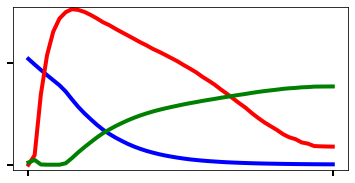

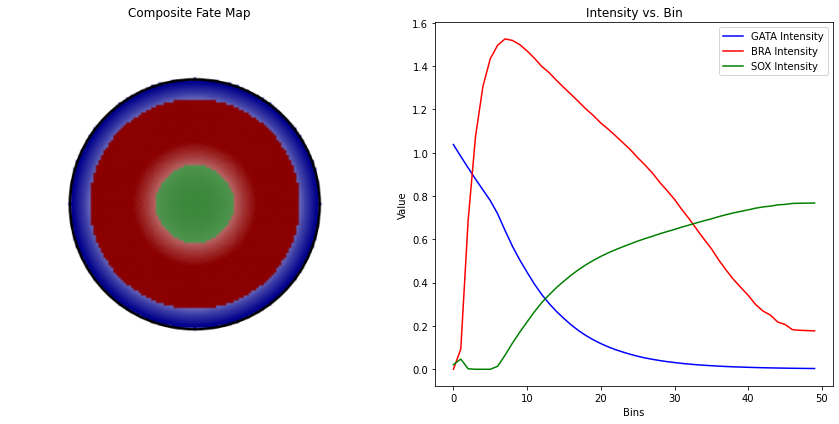

In [6]:
#RADIAL INTENSITY PLOTS

import numpy as np
import matplotlib.pyplot as plt

# Number of bins
num_bins = 50

# Calculate the bin edges
bin_edges = np.linspace(0, r_rad, num=num_bins + 1)

# Initialize arrays to hold the average intensity for each bin
average_G = np.zeros(num_bins)
average_B = np.zeros(num_bins)
average_S = np.zeros(num_bins)

# Calculate the indices for each bin
bin_indices = np.digitize(dist_from_center, bins=bin_edges, right=True)

# Calculate the average intensity for each bin
for i in range(1, num_bins + 1):
    mask = bin_indices == i
    average_G[num_bins - i] = np.mean(G_normalized[mask])
    average_B[num_bins - i] = np.mean(B_normalized[mask])
    average_S[num_bins - i] = np.mean(S_normalized[mask])

# Plot the results
plt.figure(figsize=(6, 3))
plt.plot(average_G, label='GATA Intensity', color='blue', linewidth=4)
plt.plot(average_B, label='BRA Intensity', color='red', linewidth=4)
plt.plot(average_S, label='SOX Intensity', color='green', linewidth=4)

# Set y-limits
plt.ylim(-.05, 1.55)

# Increase tick parameters
plt.tick_params(axis='both', which='major', labelsize=20, width=2, length=6)
plt.tick_params(axis='both', which='minor', labelsize=20, width=1.5, length=4)

# Set the ticks and remove the labels
plt.xticks([0, 49], labels=[])
plt.yticks([0, 1], labels=[])


plt.savefig('Intensity_vs_bin.png', bbox_inches='tight')
plt.show()

# Load the composite image
composite_img_path = 'Composite_Fate_Map.png'
composite_img = Image.open(composite_img_path)

# Plotting the figure that shows all 3 channels and the intensity vs. bin plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Display the composite image on the first subplot
ax1.imshow(composite_img)
ax1.axis('off')  # Turn off the axis
ax1.set_title('Composite Fate Map')

# Plot the intensity vs. bin graph on the second subplot
ax2.plot(average_G, label='GATA Intensity', color='blue')
ax2.plot(average_B, label='BRA Intensity', color='red')
ax2.plot(average_S, label='SOX Intensity', color='green')
ax2.set_xlabel('Bins')
ax2.set_ylabel('Value')
ax2.set_title('Intensity vs. Bin')
ax2.legend()

plt.tight_layout()
plt.savefig('Combined_Plot.png')
plt.show()

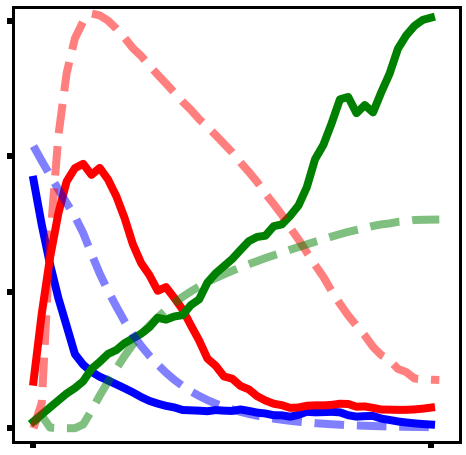

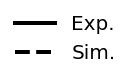

In [7]:
#COMPARE WITH EXPERIMENTAL DATA

import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import matplotlib.lines as mlines

# Function to apply Savitzky-Golay filter to smooth the data
def smooth_data(series, window_size=9, poly_order=2):
    return savgol_filter(series, window_length=window_size, polyorder=poly_order)

# Load the combined_ranges.xlsx file
df = pd.read_excel('combined_ranges.xlsx', index_col=0)

# Extract the columns for GATA, BRA, and SOX for the specific index
#index_name = "TMTD (Tetramethylthiuram disulfide)"
#index_name = "Doramapimod (BIRB 796)_4"
#index_name = "Usnic acid_2"
#index_name = "Flurbiprofen_8"
#index_name = "NSC23005 Sodium_9"
#index_name = "Hydroxyfasudil (HA-1100) HCl_2"
#index_name = "WIKI4_4"
#index_name = 'LY3200882_9'
index_name = 'Lidocaine_9'

gata_columns = df.loc[index_name, df.columns[51:100]]
bra_columns = df.loc[index_name, df.columns[100:149]]
sox_columns = df.loc[index_name, df.columns[149:198]]

# Apply smoothing to the new data
gata_columns_smooth = smooth_data(gata_columns.values)
bra_columns_smooth = smooth_data(bra_columns.values)
sox_columns_smooth = smooth_data(sox_columns.values)

# Plot the new data as solid lines
plt.figure(figsize=(8, 8))
plt.plot(gata_columns_smooth, label='GATA Intensity (simulation)', color='blue', linewidth=8)
plt.plot(bra_columns_smooth, label='BRA Intensity (simulation)', color='red', linewidth=8)
plt.plot(sox_columns_smooth, label='SOX Intensity (simulation)', color='green', linewidth=8)

# Plot the previous intensity vs. bin data as lighter dashed lines
plt.plot(average_G, label='GATA Intensity (experimental)', color='blue', linewidth=8, linestyle='dashed', alpha=0.5)
plt.plot(average_B, label='BRA Intensity (experimental)', color='red', linewidth=8, linestyle='dashed', alpha=0.5)
plt.plot(average_S, label='SOX Intensity (experimental)', color='green', linewidth=8, linestyle='dashed', alpha=0.5)

# Set y-limits
plt.ylim(-.05, 1.55)

# Increase tick parameters
plt.tick_params(axis='both', which='major', width=6, length=6)
plt.tick_params(axis='both', which='minor', width=6, length=6)

# Set x-ticks only at 0 and 48 and y-ticks only at 0, 0.5, 1.0, and 1.5
plt.xticks([0, 48], labels=[])  # Set x-ticks at 0 and 48, no labels
plt.yticks([0, 0.5, 1.0, 1.5], labels=[])  # Set y-ticks at specified values, no labels

# Make the outline of the plot (spines) thicker
ax = plt.gca()  # Get current axes
for spine in ax.spines.values():
        spine.set_linewidth(3)  # Adjust the linewidth as needed (e.g., 3 for thicker outline)

# Remove axis labels and titles
plt.xlabel('')
plt.ylabel('')

plt.savefig('Intensity_vs_bin_with_new_data_lido.png')
plt.show()

# Create a separate plot for the legend
fig, ax = plt.subplots(figsize=(2, 1))

# Create custom legend handles
exp_handle = mlines.Line2D([], [], color='black', linewidth=4, linestyle='-', label='Exp.')
sim_handle = mlines.Line2D([], [], color='black', linewidth=4, linestyle='--', label='Sim.')

# Add the custom legend handles to the legend
ax.legend(handles=[exp_handle, sim_handle], loc='center', fontsize=20, frameon=False)
ax.axis('off')

plt.savefig('legend_plot.png')
plt.show()


Simulation progress: 0.00% complete (Step 0 of 2880)
Simulation progress: 34.72% complete (Step 1000 of 2880)
Simulation progress: 69.44% complete (Step 2000 of 2880)


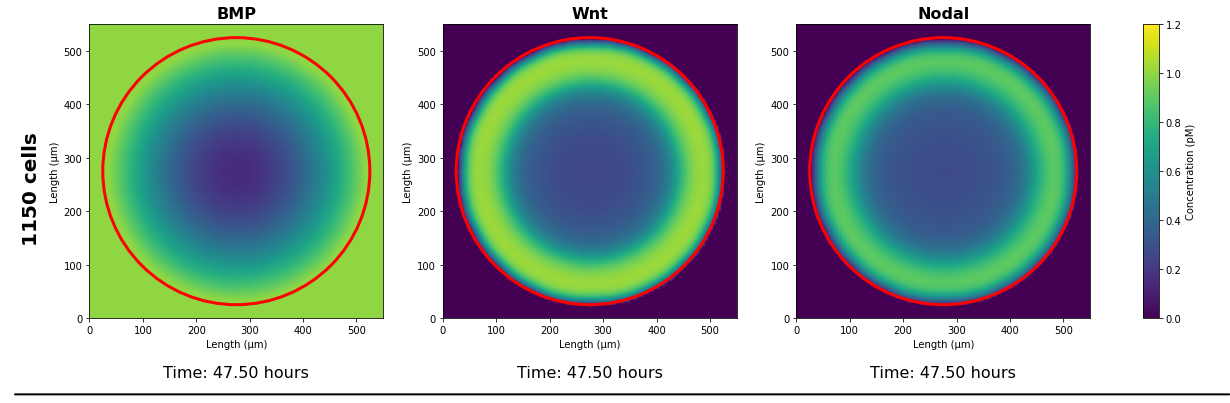

In [14]:
#CREATE VIDEOS FOR MORPHOGEN CONCENTRATIONS OVER TIME

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.colors as mcolors

# Define your cell count here: run this block for 750, 950, and 1150 sequentially
cell_count = 1150  

r_loc_mult = 1 - np.exp(-.00268 * cell_count)

# Real-world diffusion coefficients in microns^2/s
D_u_real = 0.1
D_v_real = 0.1
D_b_real = 1

# Additional parameters
su = 0.05 * 2.1e-3 * 60
sv = 0.05 * 2.1e-3 * 60
ku = 0.05 * 1.4e-3 * 60
kv = 0.05 * 1.0e-3 * 60
kb = 0.05 * 2.0e-4 * 60 
cu = 0.05 * 2.2e-4 * 60 
cv = 0.05 * 1.5e-4 * 60

Ku = 0.8
Kv = 1.5

# Density dependent variable
scaling_factor = 0.20
Kd = (1 - scaling_factor * (cell_count / 950 - 1))

# Simulation settings
dx = 5  # micrometers
grid_size = 110
D_u_per_minute = D_u_real * 60 / (dx**2)
D_v_per_minute = D_v_real * 60 / (dx**2)
D_b_per_minute = D_b_real * 60 / (dx**2)
physical_r_rad = 250  # Radius in micrometers
r_rad = physical_r_rad / dx
r_loc = r_rad * r_loc_mult
t_loc = 480  # minutes
dt = 1
total_time = 48 * 60  # minutes
frame_interval = 30  # minutes

# Initialize grids
u = np.zeros((grid_size, grid_size))
v = np.zeros((grid_size, grid_size))
b = np.ones((grid_size, grid_size))

# Center and boundary masks
center = np.array([grid_size // 2, grid_size // 2])
X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
dist_from_center = np.sqrt((X - center[0])**2 + (Y - center[1])**2)
boundary_mask_u_v = dist_from_center > r_rad
boundary_mask_b = dist_from_center > r_loc

# Reaction functions
def f(u): return (su * u**2) / (1 + Ku * u**4)
def g(u, v): return ((sv * v) / ((1 + Kv * v**2)) * u)

# General Laplacian function
def laplacian(grid):
    lap = np.zeros_like(grid)
    lap[1:-1, 1:-1] = (
        grid[2:, 1:-1] + grid[:-2, 1:-1] +
        grid[1:-1, 2:] + grid[1:-1, :-2] -
        4 * grid[1:-1, 1:-1]) / dx**2
    return lap

def update_uv(u, v, b, dt):
    u[boundary_mask_u_v] = 0
    v[boundary_mask_u_v] = 0
    laplacian_u = laplacian(u)
    laplacian_v = laplacian(v)
    du_dt = (D_u_per_minute * laplacian_u) + (Kd * (f(u)  + (kb * b) + cu)) - (ku * u)
    dv_dt = (D_v_per_minute * laplacian_v) + (g(u, v) - kv * v) + cv
    u_next = u + dt * du_dt
    v_next = v + dt * dv_dt
    return u_next, v_next, du_dt, dv_dt

def update_b(b, dt, current_time, b_updated):
    b[boundary_mask_b] = 1
    if current_time > t_loc and not b_updated:
        b[dist_from_center <= r_loc] = 0
        b_updated = True
    laplacian_b = laplacian(b)
    db_dt = D_b_per_minute * laplacian_b
    b_next = b + dt * db_dt
    return b_next, b_updated, db_dt

# Simulation loop
num_steps = int(total_time / dt)
current_time = 0

# Initialize data storage
animation_data = []
animation_data_rate = []
b_updated = False  # Initialize b_updated flag

for step in range(num_steps):
    if step % 1000 == 0:
        print(f"Simulation progress: {(step / num_steps) * 100:.2f}% complete (Step {step} of {num_steps})")
    
    # Perform updates
    b, b_updated, db_dt = update_b(b, dt, current_time, b_updated)
    u, v, du_dt, dv_dt = update_uv(u, v, b, dt)

    # Store data for animations at specified intervals
    if current_time % frame_interval < dt:
        animation_data.append((u.copy(), v.copy(), b.copy(), current_time))
        animation_data_rate.append((du_dt, dv_dt, db_dt, current_time))

    current_time += dt

# Function to update animation
def update_animation(num, data, axes):
    u, v, b, t = data[num]
    titles = ['BMP', 'Wnt', 'Nodal']
    for ax, d, title in zip(axes[:3], [b, u, v], titles):
        ax.clear()
        im = ax.imshow(d, cmap=viridis, extent=[0, grid_size*dx, 0, grid_size*dx], vmin=0, vmax=1.2)
        ax.set_title(f'{title}', fontsize=16, fontweight='bold')
        ax.text(0.5, -0.2, f'Time: {t / 60:.2f} hours', fontsize=16, ha='center', transform=ax.transAxes)
        ax.set_xlabel('Length (μm)')
        ax.set_ylabel('Length (μm)')
        colony_circle = plt.Circle((center[0]*dx, center[1]*dx), r_rad*dx, color='red', fill=False, linewidth=3)
        ax.add_patch(colony_circle)
    # Add colorbar to the fourth subplot
    fig.colorbar(im, cax=axes[3], orientation='vertical', label='Concentration (pM)')

# Create figure with 4 subplots (3 for images, 1 for scale bar)
fig, axes = plt.subplots(1, 4, figsize=(18, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.05]})

# Adjust layout to leave room for vertical text
plt.subplots_adjust(left=0.07, bottom=0.2)

# Add vertical text on the far left of the entire figure
plt.text(0.03, 0.5, f'{cell_count} cells', fontsize=20, fontweight='bold', color='black',
         ha='center', va='center', rotation='vertical', transform=fig.transFigure)

# Add the horizontal line across the bottom, spanning all subplots
plt.annotate('', xy=(0.01, 0.02), xycoords='figure fraction', xytext=(0.95, 0.02), 
             arrowprops=dict(arrowstyle='-', color='black', lw=2))


# Create animation
conc_ani = FuncAnimation(fig, update_animation, frames=len(animation_data),
                         fargs=(animation_data, axes), interval=200, blit=False)
conc_ani.save(f'concentration_simulation_{cell_count}_viridis.mp4', fps=8, extra_args=['-vcodec', 'libx264'])

plt.show()

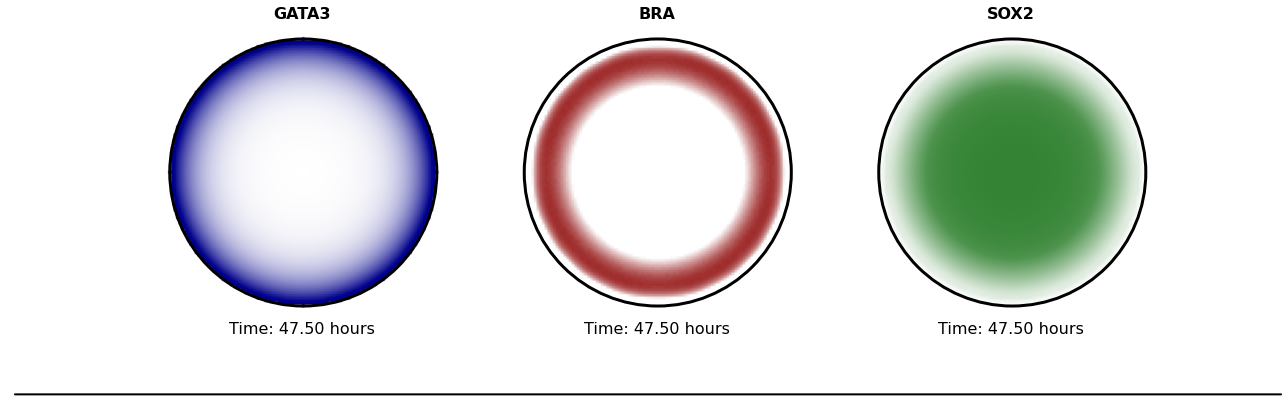

In [15]:
#CREATE CORRESPONDING CELL FATE VIDEO

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import LinearSegmentedColormap

# Define custom colormaps for GATA3, BRA, and SOX
gata3_cmap = LinearSegmentedColormap.from_list('gata3_cmap', ['white', 'darkblue'], N=256)
bra_cmap = LinearSegmentedColormap.from_list('bra_cmap', ['white', 'darkred'], N=256)
sox_cmap = LinearSegmentedColormap.from_list('sox_cmap', ['white', 'darkgreen'], N=256)

# Define figure and axes for the animation
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
titles = ['GATA3', 'BRA', 'SOX2']
cmaps = [gata3_cmap, bra_cmap, sox_cmap]

# Adjust layout to leave room at the bottom
plt.subplots_adjust(bottom=0.2)

# Create placeholders for data to be updated during the animation
images = []
texts = []  # List to hold text annotations for the timestamps
for i, ax in enumerate(axs):
    img = ax.imshow(np.zeros_like(animation_data[0][0]), cmap=cmaps[i], vmin=0, vmax=1)
    ax.set_title(titles[i], fontsize=16, fontweight='bold')
    ax.axis('off')
    colony_circle = plt.Circle(center, r_rad, color='black', fill=False, linewidth=3)
    ax.add_patch(colony_circle)
    images.append(img)
    text = ax.text(0.5, -.05, '', fontsize=16, ha='center', transform=ax.transAxes)
    texts.append(text)

# Add the horizontal line across the bottom, spanning all subplots
plt.annotate('', xy=(0.01, 0.02), xycoords='figure fraction', xytext=(0.99, 0.02), 
             arrowprops=dict(arrowstyle='-', color='black', lw=2))

# Initialize cumulative variables for GATA3 and BRA calculations globally
cumulative_b = np.zeros_like(animation_data[0][2])
cumulative_change_v = np.zeros_like(animation_data[0][0])

# Update function for the animation
def update_fate_maps(frame_idx):
    global cumulative_b, cumulative_change_v
    
    # Get current data for concentrations and rate changes
    u, v, b, current_time = animation_data[frame_idx]
    rate_change_v = animation_data_rate[frame_idx][1]

    # Accumulate the b values for GATA3 calculation
    cumulative_b += b * dt

    # GATA CALCULATION
    Cg = 0.1
    GATA_expression = cumulative_b / (1 + np.exp(-Cg * (dist_from_center - r_rad)))
    GATA_expression[boundary_mask_u_v] = 0

    # BRA CALCULATION using the rate of change of v
    condition_met = (u > 0.7)
    cumulative_change_v += condition_met * rate_change_v * dt
    BRA_expression = cumulative_change_v * 3300
    BRA_expression[boundary_mask_u_v] = 0

    # SOX CALCULATION
    SOX_expression = np.maximum(0, 1 * (48 - GATA_expression - 0.20 * BRA_expression))
    SOX_expression[boundary_mask_u_v] = 0

    # Normalize the expressions
    G_normalized = GATA_expression / 45
    B_normalized = BRA_expression / 50
    S_normalized = SOX_expression / 60

    # Update the images with the latest normalized values
    images[0].set_array(G_normalized)
    images[1].set_array(B_normalized)
    images[2].set_array(S_normalized)
    
    # Update the time stamp below each title
    for ax, text in zip(axs, texts):
        text.set_text(f'Time: {current_time / 60:.2f} hours')

# Create the animation
ani = FuncAnimation(fig, update_fate_maps, frames=len(animation_data), interval=200, repeat=False)

# Save the animation
ani.save(f'Fate_Maps_Animation_{cell_count}.mp4', fps=8, extra_args=['-vcodec', 'libx264'])

plt.show()

In [16]:
#AFTER CREATING ALL 6 videos (3 at each density), run this block to stich into a composite video

from moviepy.editor import VideoFileClip, clips_array

# Load all the video clips
concentration_750 = VideoFileClip("concentration_simulation_750_viridis.mp4")
concentration_950 = VideoFileClip("concentration_simulation_950_viridis.mp4")
concentration_1150 = VideoFileClip("concentration_simulation_1150_viridis.mp4")

fate_750 = VideoFileClip("Fate_Maps_Animation_750.mp4")
fate_950 = VideoFileClip("Fate_Maps_Animation_950.mp4")
fate_1150 = VideoFileClip("Fate_Maps_Animation_1150.mp4")

# Determine the fate map crop dimensions
crop_percentage = 0.2
fate_width, fate_height = fate_750.size
left_crop = int(fate_width * crop_percentage / 2)
right_crop = fate_width - left_crop

# Crop fate map clips by removing 20% from each side
fate_750_cropped = fate_750.crop(x1=left_crop, x2=right_crop)
fate_950_cropped = fate_950.crop(x1=left_crop, x2=right_crop)
fate_1150_cropped = fate_1150.crop(x1=left_crop, x2=right_crop)

# Combine the videos into a 3x2 grid without white space between columns
combined_clip = clips_array([
    [concentration_750, fate_750_cropped],
    [concentration_950, fate_950_cropped],
    [concentration_1150, fate_1150_cropped]
], bg_color=None)  # Set the background color to None to avoid white space

# Set the duration of the combined clip to the minimum duration of the input clips
min_duration = min(
    concentration_750.duration, concentration_950.duration, concentration_1150.duration,
    fate_750.duration, fate_950.duration, fate_1150.duration
)
combined_clip = combined_clip.set_duration(min_duration)

# Write the combined video to a file with correct codec settings
combined_clip.write_videofile("combined_animations_cropped.mp4", fps=8, codec="libx264", preset="medium")


t:   2%|▏         | 2/96 [00:00<00:07, 12.43it/s, now=None]

Moviepy - Building video combined_animations_cropped.mp4.
Moviepy - Writing video combined_animations_cropped.mp4



Moviepy - Done !
Moviepy - video ready combined_animations_cropped.mp4
